In [21]:
import gym
import random, math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
from scripts.reinforce_PPORLHF import reinforce_rwd2go_PPO_RLHF
from scripts.utils import pref_save, pref_load

from scripts.model import getPolicy
import pickle
import torch
import torch.nn.functional as F

from scripts.reinforce_PPORLHF import reinforce_rwd2go_PPO_RLHF

%load_ext autoreload
%autoreload 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [22]:
SEED=0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

ENV_NAME = 'Acrobot-v1'

env = gym.make(ENV_NAME)

K = 1000

POLICY1_NAME = "policies/policy1.pth"
POLICY2_NAME = "policies/policy2_with_mean.pth"
pref_data = pref_load(f"pref_data/pref_data_{K}_{ENV_NAME}.pickle")

/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Epoch 1/10 — avg loss: 16.9932
Epoch 2/10 — avg loss: 13.3904
Epoch 3/10 — avg loss: 10.3039
Epoch 4/10 — avg loss: 7.7137
Epoch 5/10 — avg loss: 5.5891
Epoch 6/10 — avg loss: 3.8870
Epoch 7/10 — avg loss: 2.4699
Epoch 8/10 — avg loss: 1.4676
Epoch 9/10 — avg loss: 1.0911
Epoch 10/10 — avg loss: 0.9303


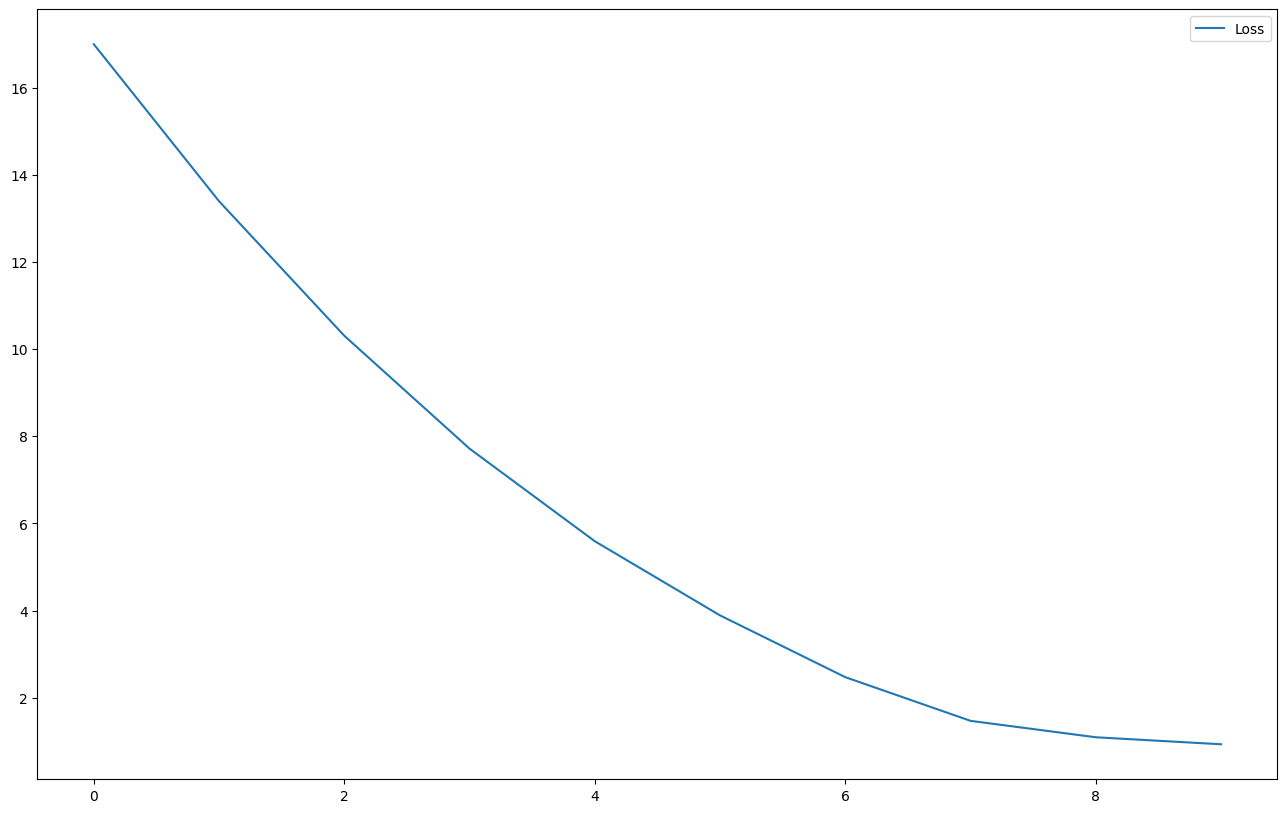

In [23]:
class RewardModel(nn.Module):
    def __init__(self, state_size=6, action_size=1, hidden_size=32):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return x

    def predict_reward(self, state, action):
        state = state
        action = torch.tensor(action).reshape(1,1)  
        
        state_action = torch.cat((state, action), dim=1)
        reward = self.forward(state_action).cpu()
        return reward
    

lr        = 3e-3
epochs    = 10

reward_model = RewardModel()

optimizer = torch.optim.Adam(reward_model.parameters(), lr=lr)

def trajectory_reward(reward_model, states, actions):
    total_reward = torch.tensor(0., device=device)
    for s, a in zip(states, actions):
        s_t = torch.tensor(s, dtype=torch.float32, device=device)
        reward = reward_model.predict_reward(s_t.unsqueeze(0), a).squeeze(0)
        total_reward += reward.squeeze(0)
    return total_reward

losses_reward_model = []
for epoch in range(1, epochs+1):
    total_loss = 0.0
    
    for s0, tau_plus, tau_minus in pref_data:

        reward_plus = trajectory_reward(reward_model, tau_plus["states"], tau_plus["actions"])
        reward_minus = trajectory_reward(reward_model, tau_minus["states"], tau_minus["actions"])
        
        stacked = torch.stack([reward_plus, reward_minus])
        log_Z   = torch.logsumexp(stacked, dim=0)
        total_loss += - (reward_plus - log_Z) 

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    avg_loss = total_loss / len(pref_data)
    losses_reward_model.append(avg_loss.detach().numpy().item())
    
    print(f"Epoch {epoch}/{epochs} — avg loss: {avg_loss:.4f}")

plt.plot(np.arange(epochs), losses_reward_model, label="Loss")
plt.legend()
plt.show()

Ep 100	avg100: -154.15
Ep 200	avg100: -142.16
Ep 300	avg100: -126.47
Ep 400	avg100: -115.98
Ep 500	avg100: -121.84
Ep 600	avg100: -123.94
Ep 700	avg100: -130.28
Ep 800	avg100: -125.97
Ep 900	avg100: -119.14
Ep 1000	avg100: -117.86
Ep 1100	avg100: -114.24
Ep 1200	avg100: -113.72
Ep 1300	avg100: -114.88
Ep 1400	avg100: -112.21
Ep 1500	avg100: -109.02
Ep 1600	avg100: -108.26
Ep 1700	avg100: -115.99
Ep 1800	avg100: -107.38
Ep 1900	avg100: -106.66
Ep 2000	avg100: -99.84
Ep 2100	avg100: -109.63
Ep 2200	avg100: -101.40
Ep 2300	avg100: -100.83
Ep 2400	avg100: -97.95
Ep 2500	avg100: -98.98
Ep 2600	avg100: -96.53
Ep 2700	avg100: -101.22
Ep 2800	avg100: -95.82
Ep 2900	avg100: -91.49


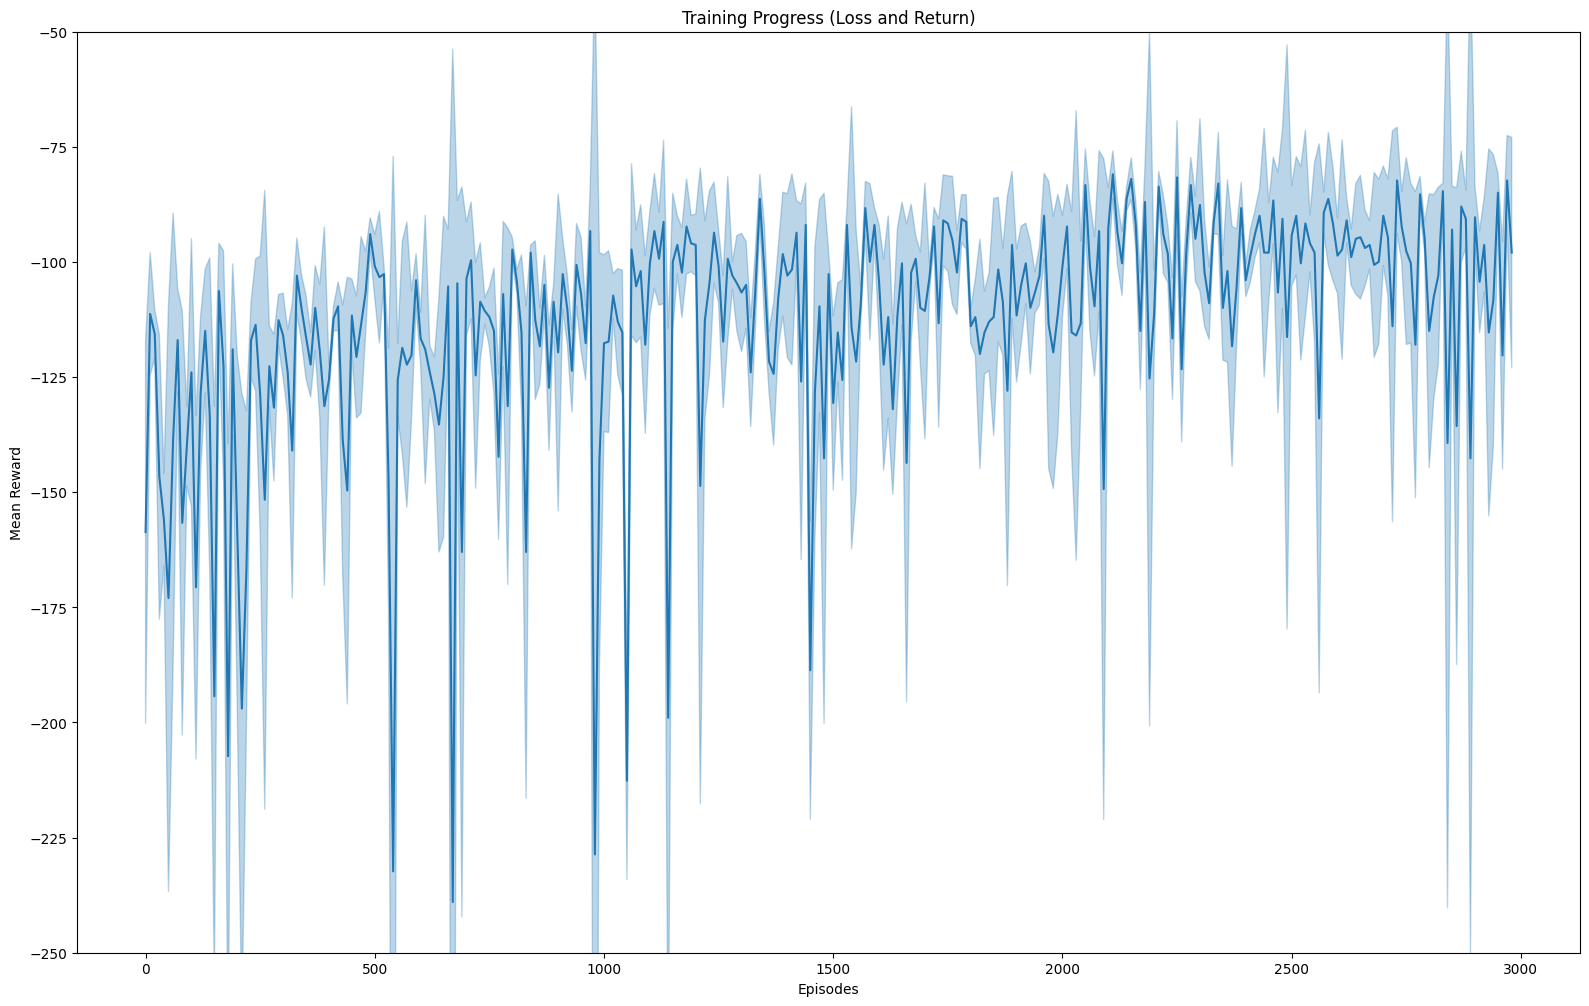

In [26]:
policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy2.load_state_dict(torch.load(POLICY2_NAME))


opt1 = optim.Adam(policy2.parameters(), lr=1e-3)
reward_model.eval()

reward_evaluation_every=10
losses, mean_returns, std_returns = reinforce_rwd2go_PPO_RLHF(env, policy2, opt1, reward_model, n_episodes=3000, reward_evaluation_every=reward_evaluation_every);

x = np.arange(len(losses)) * reward_evaluation_every
plt.plot(x, mean_returns, color="tab:blue", label="Mean Reward")
plt.fill_between(x, mean_returns - std_returns, mean_returns + std_returns, color="tab:blue", alpha=0.3)
plt.ylabel("Mean Reward")
plt.xlabel("Episodes")

plt.ylim([-250, -50])

plt.tight_layout()
plt.title("Training Progress (Loss and Return)")
plt.show()